In [1]:
import datetime
import rasterio as rs
#import scipy.interpolate as spint

def get_date(fl):
    '''Parse out data from the SNODAS file name'''
    year = fl.split('__')[-1].split('.')[0][11:15]
    month = fl.split('__')[-1].split('.')[0][15:17]
    day = fl.split('__')[-1].split('.')[0][17:19]
    
    return '%s-%s-%s'%(year,month,day)

def get_WaterYear(dt):
    '''returns water year for a datetime object'''
    strt = datetime.datetime(dt.year,10,1)
    nd = datetime.datetime(dt.year,12,31)
    
    if (dt >= strt) & (dt <= nd):
        return dt.year+1
    else:
        return dt.year

def check_empty(vals):
    '''Check for empty series of pixels in the raster stack'''
    
    if np.sum(np.isnan(vals)) > 0:
        return 0
    else:
        return 1
    
def DOWY(date):
    '''compute day of water year from a YYYY-MM-DD date string'''
    if date == 'None':
        return np.NaN
    else:
        year = int(date.split('-')[0])
        month = int(date.split('-')[1])
        day = int(date.split('-')[2])
        
        date = datetime.datetime(year,month,day)

        if date <= datetime.datetime(year,9,30):
            return (date - datetime.datetime(year - 1,10,1)).days
        else: 
            return (date - datetime.datetime(year,10,1)).days + 1
        

def get_dons(vals,dates=[]):
    '''Pull the date of no snow'''
    if np.nansum(vals) > 0:
        dons = dates[np.nanargmin(vals)] # return the first date that the pack hits 0
        return DOWY(str(dons.date()))
    else: return np.NaN
    
def get_peakSWE(vals):
    '''Pull the peak SWE value'''
    
    if np.nansum(vals) > 0:
        peakSWE = np.nanmax(vals)
        return peakSWE

    else:
        return np.NaN

def get_doPeakSWE(vals,dates=[]):
    '''Pull the date of peak SWE
    return a datetime object
    '''
    if np.nansum(vals) > 0:
        dops = dates[np.nanargmax(vals)] # return the first date that the pack maxes out
        return DOWY(str(dops.date()))
    
    else: return np.NaN

def savetiff(inarray,outfl,profile):
    '''Save a geotiff of an array using the file name and geospatial profile provided.'''
    #profile['dtype'] = inarray.dtype
    
    with rs.open(outfl,'w',**profile) as ds:
        ds.write(inarray,1)

In [173]:
DOWY(str(dates[np.nanargmax(test)].date()))

195

In [171]:
test = np.array([np.NaN,np.NaN,0.4,np.NaN,0.5,0.2,0.1,0,np.NaN,np.NaN,np.NaN])
dates = pd.date_range(start='2010-4-10',freq='D',periods=len(test))

#df = pd.DataFrame()
#df['swe'] = test
#df.index = pd.DatetimeIndex(dates)

#df.swe.max()

In [2]:
def process_year(wy):
    '''
    Generate GeoTiffs of peak SWE, date of snow dissapearance, and date of peak SWE. Dates are
    reported as day of water year of the water year provided.
    
    In:
    water year
    
    Out:
    None, but 3 geotiffs of the above variables are saved to the hard-coded paths below.
    '''
    fileList = files.loc[files.WaterYear==wy] # extract the files necessary
    n = len(fileList) # number of files or raster stack depth

    # load a test file to get the array dimensions
    with rs.open(fileList.name[0]) as ds:
        j,k = ds.read(1).shape
        profile = ds.profile

    tmp = np.ndarray((n,j,k),dtype=np.float32) # preallocate the array
    tmp[:,:,:] = np.NaN # fill with NaNs
    
    i = 0
    for fl in fileList.name:

        with rs.open(fl) as ds:
            d = ds.read(1)
            
            jj,kk = d.shape
            if (jj != j) | (kk != k):
                print('Arrays are not the same shape, skipping slice %s'%i)
                del d
                i += 1
                continue
            else:
                dd = np.array(d,dtype = np.float32)
                del d
                dd[dd==-9999] = np.NaN
                tmp[i,:,:] = dd/1000. # pull the data into the stack and scale it
                i += 1


    # reshape the array into a big data frame
    cells = []
    js = []
    ks = []
    for i in range(j):
        for o in range(k):
            cells.append(tmp[:,i,o])
            js.append(i)
            ks.append(o)

    del tmp

    dat = pd.DataFrame()
    dat['jcoord'] = js
    dat['kcoord'] = ks
    dat['vals'] = cells
    
    dates = fileList.index
    
    # dat['empty'] = dat.vals.map(check_empty) # check for empty cells
    
    # process the metrics
    dat['dowy_noSnow'] = dat.vals.apply(get_dons, dates=dates)
    dat['PeakSWE'] = dat.vals.map(get_peakSWE)
    dat['dowy_peakSWE'] = dat.vals.apply(get_doPeakSWE, dates=dates)
    
    # convert dates to day of water year
    #dat[] = dat.dons.map(DOWY)
    #dat[] = dat.doPeakSWE.map(DOWY)
    
    # convert data frames to arrays
    dowyNoSnow = np.ndarray((j,k),dtype = np.float32) # preallocate
    dowyPeakSWE = dowyNoSnow.copy() # copy for each variable
    PeakSWE = dowyNoSnow.copy()
    
    # populate the arrays
    dowyNoSnow[dat.jcoord,dat.kcoord] = dat.dowy_noSnow
    dowyPeakSWE[dat.jcoord,dat.kcoord] = dat.dowy_peakSWE
    PeakSWE[dat.jcoord,dat.kcoord] = dat.PeakSWE
    
    del dat
    
    ndval = -9999
    # make the NaN the no data value
    dowyNoSnow[np.isnan(dowyNoSnow)] = ndval
    dowyPeakSWE[np.isnan(dowyPeakSWE)] = ndval
    PeakSWE[np.isnan(PeakSWE)] = ndval

    # save the output
    profile['dtype'] = 'float32' # fix profile for the new arrays
    profile['nodata'] = ndval # fix the no data value
    
    outfl = './data/snodas_peakSWE_wy%s.tiff'%wy
    savetiff(PeakSWE,outfl,profile)

    outfl = './data/snodas_DOWYpeakSWE_wy%s.tiff'%wy
    savetiff(dowyPeakSWE,outfl,profile)

    outfl = './data/snodas_DOWYnoSnow_wy%s.tiff'%wy
    savetiff(dowyNoSnow,outfl,profile)
    
    return None

In [3]:
# generate a list of file names
files = pd.DataFrame()
files['name'] = glob.glob('./data/SNODAS_SWE/SnowWaterEquivalent/*/*.tif')
files['datetime'] = files.name.map(get_date)
files.index = pd.DatetimeIndex(files.datetime)
del files['datetime']
files['WaterYear'] = files.index.map(get_WaterYear)
files.sort_index(ascending=True,inplace=True)

In [4]:
process_year(2004)

Arrays are not the same shape, skipping slice 157


/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [44]:
for wy in files.WaterYear.unique():
    print('Starting WY: %s'%wy)
    process_year(wy)
    print('WY %s finished!'%wy)

Starting WY: 2004
Arrays are not the same shape, skipping slice 157


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [99]:
dowyNoSnow[dowyNoSnow<0] = np.NaN
dowyPeakSWE[dowyPeakSWE<0] = np.NaN
PeakSWE[PeakSWE<0] = np.NaN

/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [114]:
np.nanmin(dowyNoSnow)

304.0

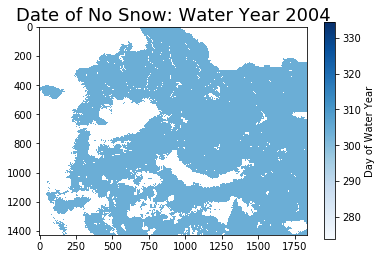

In [111]:
plt.imshow(dowyNoSnow,cmap='Blues')
plt.colorbar(label = 'Day of Water Year')
plt.title('Date of No Snow: Water Year %s'%wy,fontsize=18)

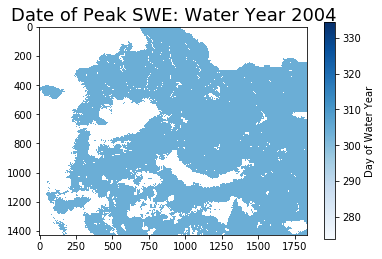

In [115]:
plt.imshow(dowyPeakSWE,cmap='Blues')
plt.colorbar(label = 'Day of Water Year')
plt.title('Date of Peak SWE: Water Year %s'%wy,fontsize=18)

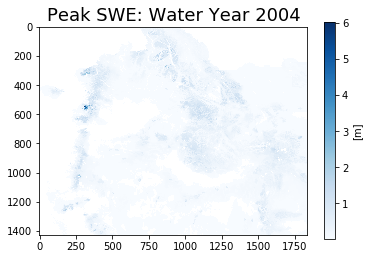

In [116]:
plt.imshow(PeakSWE,cmap='Blues')
plt.colorbar(label = '[m]')
plt.title('Peak SWE: Water Year %s'%wy,fontsize=18)

/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [8]:
DOWY('2010-8-01')

304

In [9]:
dates

NameError: name 'dates' is not defined

In [10]:
wy = 2004
fileList = files.loc[files.WaterYear==wy] # extract the files necessary

In [11]:
fileList.tail()

,name,WaterYear
datetime,,
2004-07-27,./data/SNODAS_SWE/SnowWaterEquivalent/July/us_...,2004
2004-07-28,./data/SNODAS_SWE/SnowWaterEquivalent/July/us_...,2004
2004-07-29,./data/SNODAS_SWE/SnowWaterEquivalent/July/us_...,2004
2004-07-30,./data/SNODAS_SWE/SnowWaterEquivalent/July/us_...,2004
2004-07-31,./data/SNODAS_SWE/SnowWaterEquivalent/July/us_...,2004


In [12]:
DOWY('2004-07-31')

304

In [13]:
DOWY('2010-07-31')

303